## CALC log analysis

The following notebook assumes you have downloaded the CALC logs as CSV from [api.data.gov/admin](https://api.data.gov/admin/) and saved them as `logs.csv` in the same directory as this notebook.

In [2]:
import pandas

In [3]:
rows = pandas.read_csv('logs.csv', nrows=None, index_col=False, usecols=[
    'Time',
    'Method',
    'URL',
    'State',
    'Country',
    'City',
    'Status',
    'IP Address',
])

The following step is optional; we're removing identical requests coming from the same IP address. This might not actually be a great idea, especially if multiple actual users are behind the same IP address.

In [4]:
rows.drop_duplicates(subset=['Method', 'URL', 'IP Address'], inplace=True)

del rows['IP Address']

Now we'll filter only successful requests to the `/rates/` endpoint, which is the one used when users click the **Search** button (or initially load the page). We'll also parse the query string and add new columns that represent information about the search criteria.

In [13]:
from urllib.parse import urlparse, parse_qsl

RATES_URL = 'https://api.data.gov/gsa/calc/rates/'

rates = rows
rates = rates[rates['Method'] == 'GET']
rates = rates[rates['Status'] == 200]
rates = rates[rates['URL'].str.startswith(RATES_URL)]
rates['Time'] = rates['Time'].apply(pandas.to_datetime)

del rates['Method']
del rates['Status']

queries = rates['URL'].apply(
    lambda url: dict(parse_qsl(urlparse(url).query))
).apply(pandas.Series)

In [14]:
FIELD_DEFAULTS = {
    'Search terms': '',
    'Minimum experience': 0,
    'Maximum experience': 45,
    'Education level': '',
    'Worksite': '',
    'Business size': '',
    'Schedule': '',
    'Contract year': 'current',
    'Proposed price': '',
    'Query type': 'match_all',
    'Sort': 'current_price',
    'Rows excluded': 0,
}

rates['Search terms'] = queries['q'].str.lower().str.strip().str.replace(r',[ ]*$', '')
rates['Minimum experience'] = queries['min_experience'].apply(pandas.to_numeric)
rates['Maximum experience'] = queries['max_experience'].apply(pandas.to_numeric)
rates['Education level'] = queries['education']
rates['Worksite'] = queries['site']
rates['Business size'] = queries['business_size']
rates['Schedule'] = queries['schedule']
rates['Contract year'] = queries['contract-year']
rates['Proposed price'] = queries['proposed-price']
rates['Query type'] = queries['query_type']
rates['Sort'] = queries['sort']
rates['Rows excluded'] = queries['exclude'].str.split(',').str.len()

rates = rates.fillna(FIELD_DEFAULTS)

## Popular search terms

In [40]:
rates['Search terms'].value_counts().head(30).to_frame('Number of searches')

,Number of searches
,3629
subject matter expert,1444
project manager,1338
engineer,1125
program manager,1099
senior engineer,708
software engineer,593
consultant,447
systems engineer,435
training specialist,398


## Search customization

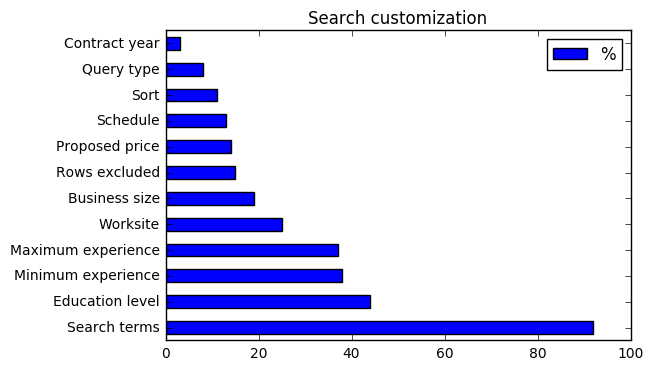

In [44]:
%matplotlib inline

total_rates = rates.shape[0]
percentages = {}

for field, default in FIELD_DEFAULTS.items():
    non_default_rates = rates[rates[field] != default].shape[0]
    percentages[field] = int(non_default_rates / total_rates * 100)

pandas.Series(percentages).to_frame('%').sort_values(by='%', ascending=False)\
  .plot(kind='barh', title="Search customization")

### How many searches had *any* customization, other than search term?

In [60]:
customized = pandas.Series(False, rates.index)
customization_factors = pandas.Series(0, rates.index)

for field, default in FIELD_DEFAULTS.items():
    if field == 'Search terms':
        continue
    field_was_not_default = rates[field] != default
    customized = customized | field_was_not_default
    customization_factors += field_was_not_default.astype(int)

customized_rates = rates[customized]

customized_rates.shape[0] / rates.shape[0]

0.7674321328481198

### Distribution of queries by number of search customizations

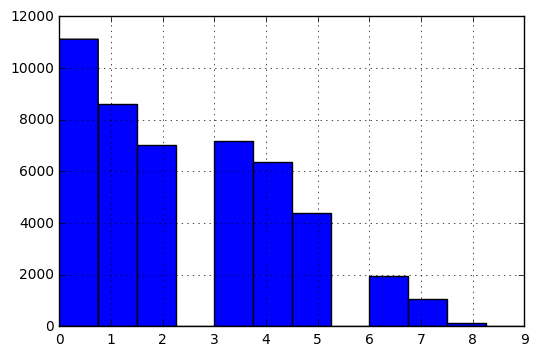

In [63]:
customization_factors.hist(bins=len(FIELD_DEFAULTS))

## Distribution of minimum experience

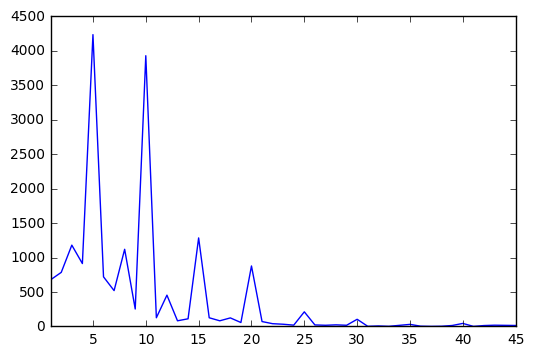

In [26]:
%matplotlib inline

rates[rates['Minimum experience'] > 0]['Minimum experience'].value_counts().sort_index().plot()

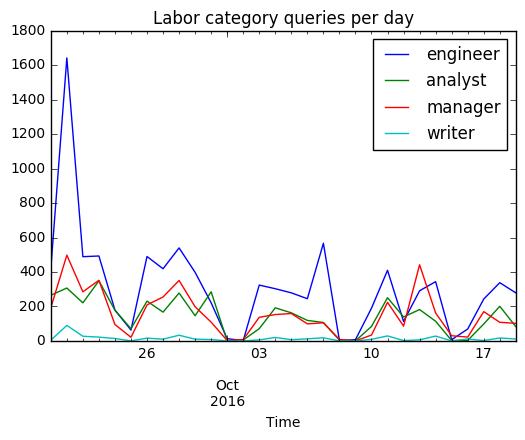

In [41]:
timerates = rates.set_index(['Time'])

r = pandas.DataFrame()

for term in ['engineer', 'analyst', 'manager', 'writer']:
    r[term] = (timerates['Search terms'].str.contains(term)).astype(int).resample('D').sum()

r.plot(title='Labor category queries per day')

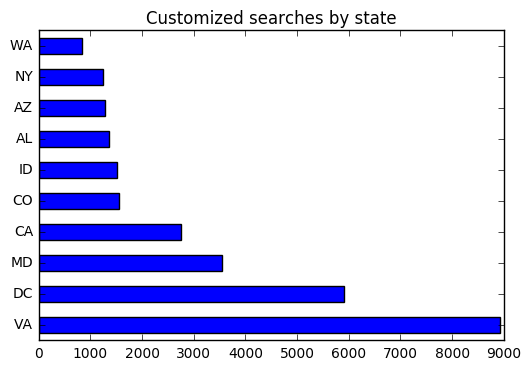

In [112]:
(customized_rates['State'])\
  .value_counts()[:10].plot(kind='barh', title="Customized searches by state")

## Autocomplete searches

When the user types in the search terms field, the autocomplete suggestions are returned via an API. The following contains statistics about the types of searches being performed here.

In [105]:
SEARCH_URL = 'https://api.data.gov/gsa/calc/search/'

searches = rows
searches = searches[searches['Method'] == 'GET']
searches = searches[searches['Status'] == 200]
searches = searches[searches['URL'].str.startswith(SEARCH_URL)]

del searches['Method']
del searches['Status']

search_queries = searches['URL'].apply(
    lambda url: dict(parse_qsl(urlparse(url).query))
).apply(pandas.Series)

### Popular autocomplete searches for fixed-length search terms

In [110]:
SEARCH_LEN = int(search_queries['q'].str.len().median())

df = search_queries['q'].str.lower().str.slice(0, SEARCH_LEN).value_counts().to_frame('Number of searches')
df[df.index.str.len() == SEARCH_LEN].head(30)

,Number of searches
engin,1866
manag,1238
techn,1137
admin,1077
analy,1023
consu,866
speci,785
progr,677
proje,582
devel,567
